In [ ]:
import pandas as pd #import libraries for further preprocessing
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTEENN, SMOTETomek  
from imblearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV # for model hypertuning
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc,
                             plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, 
                             precision_recall_curve, ConfusionMatrixDisplay, matthews_corrcoef, make_scorer)

In [ ]:
import tensorflow as tf # import libraries for NN building
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import MaxNorm

In [ ]:
try: #import library for hypertuning NN's
    import scikeras
except ImportError:
    !python -m pip install scikeras[tensorflow]

In [ ]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [ ]:
from scikeras.wrappers import KerasClassifier # to wrap model for grid search

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/trainset.csv" "train.csv" #import processed datasets
!cp "/content/drive/My Drive/testset.csv" "test.csv"
!cp "/content/drive/My Drive/devset.csv" "dev.csv"

In [ ]:
dfs = []
dfn = []
le = LabelEncoder()
dfn = pd.read_csv("test.csv",parse_dates=['created_at'])
dfs.append(pd.read_csv("train.csv",parse_dates=['created_at']))
dfs.append(pd.read_csv("dev.csv",parse_dates=['created_at']))
dfs = pd.concat(dfs, axis=0,ignore_index=True)
dfs['b'] = 1
dfs['friends_to_followers_ratio'] = dfs['friends_count']/dfs[['followers_count','b']].max(axis=1)
dfn['b'] = 1
dfn['friends_to_followers_ratio'] = dfn['friends_count']/dfn[['followers_count','b']].max(axis=1)
dfs = dfs.replace([np.inf, -np.inf], np.nan)
dfn = dfn.replace([np.inf, -np.inf], np.nan)
dfs = dfs.replace(np.nan, 0)
dfn = dfn.replace(np.nan, 0)
dfs['verified'] = le.fit_transform(dfs['verified'])#Transform for T/F to 1/0
dfn['verified'] = le.fit_transform(dfn['verified'])
x_train = dfs
x_test = dfn
x_tr = dfs['verified']
x_tt = dfn['verified']
y_train = x_train['label']
y_test = x_test['label']
x_train = x_train.drop(columns=['verified','geo_enabled','tweet','b','id_str', 'ID', 'screen_name', 'name', 'location', 'profile_location', 'description', 'default_profile_image', 'default_profile', 'has_extended_profile', 'protected', 'created_at', 'utc_offset', 'url', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile','is_translator','profile_background_color','is_translation_enabled','time_zone', 'profile_image_url_https', 'profile_use_background_image', 'profile_sidebar_border_color','profile_text_color', 'contributors_enabled', 'lang', 'profile_image_url', 'profile_link_color','profile_sidebar_fill_color', 'entities','label']) #drop all columns of features not needed for my model
x_test = x_test.drop(columns=['verified','geo_enabled','tweet','b','id_str', 'ID', 'screen_name', 'name', 'location', 'profile_location', 'description', 'default_profile_image', 'default_profile', 'has_extended_profile', 'protected', 'created_at', 'utc_offset', 'url', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile','is_translator','profile_background_color','is_translation_enabled','time_zone', 'profile_image_url_https', 'profile_use_background_image', 'profile_sidebar_border_color','profile_text_color', 'contributors_enabled', 'lang', 'profile_image_url', 'profile_link_color','profile_sidebar_fill_color', 'entities','label'])

In [ ]:
x_trains = StandardScaler().fit_transform(x_train) #Scale data excluding verified boolean features
x_tests = StandardScaler().fit_transform(x_test)
x_tr = pd.concat([pd.DataFrame(x_trains),x_tr],axis=1) # combine scaled feature with "verified" feature
x_tt = pd.concat([pd.DataFrame(x_tests),x_tt], axis=1)
x_tr.columns=['followers_count',	'friends_count',	'listed_count',	'favourites_count',	'statuses_count',	'mentions',	'hashtags',	'urls',	'retweets',	'subjectivity_score',	'compound',	'neg',	'neu',	'pos',	'Text_sim',	'friends_to_followers_ratio','verified'] #label columsn of training and test
x_tt.columns=['followers_count',	'friends_count',	'listed_count',	'favourites_count',	'statuses_count',	'mentions',	'hashtags',	'urls',	'retweets',	'subjectivity_score',	'compound',	'neg',	'neu',	'pos',	'Text_sim',	'friends_to_followers_ratio','verified']

In [ ]:
x_tr['verified']=x_tr['verified'].replace(0,-1)
x_tt['verified']=x_tt['verified'].replace(0,-1) # transform verified feature binary data from (0/1) to (-1/1) another form of standardising binary data improves NN performance

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b566fce50>,
      dtype=object)

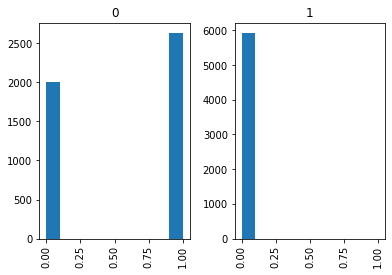

In [ ]:
dfs.hist(column='verified', by='label')#visualise data

In [ ]:
def create_model(dropout_rate, weight_constraint): #function to provide model for gridsearch
	# create model
	model = Sequential()
	model.add(Dense(30, input_shape=(17,), activation='relu', kernel_constraint=MaxNorm(weight_constraint)))
	model.add(Dropout(dropout_rate))
	model.add(Dense(30, activation='relu', kernel_constraint=MaxNorm(weight_constraint)))
	model.add(Dropout(dropout_rate))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)
# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_tr, y_train, epochs=50, batch_size=10)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Gridsearch steps based off  https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ 

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50) #early stopping to find the model that produced the lowest error on validation set for approach 1
model = Sequential()
model.add(Dense(30, input_shape=(17,), activation='relu', kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.1))
model.add(Dense(30, activation='relu', kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
# create model
# opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
model.fit(x_tr,y_train,validation_split=0.40, epochs=50, batch_size=10, verbose=0, callbacks=[es]) 

In [ ]:
model.evaluate(x_tt, y_test) #test model on test dataset

In [ ]:
y_pred = (model.predict(x_tt) > 0.5).astype("int32") #create predicted labels for test set
print('\nmatthews_corrcoef:',matthews_corrcoef(y_test, y_pred)) #apply evaluation metrics on predicted labels to quantify models performance
print('\nf1:',f1_score(y_test, y_pred))
print('\nprecision:',precision_score(y_test, y_pred))
print('\nrecall:',recall_score(y_test, y_pred))
print('\nroc:',roc_auc_score(y_test, y_pred))
print('\naccuracy:',accuracy_score(y_test, y_pred))

In [ ]:
def create_network(): #for model CV evaluation Approach 2
  network = Sequential()
  network.add(Dense(30, input_shape=(17,), activation='relu', kernel_constraint=MaxNorm(3)))
  network.add(Dropout(0.1))
  network.add(Dense(30, activation='relu', kernel_constraint=MaxNorm(3)))
  network.add(Dropout(0.1))
  network.add(Dense(1, activation='sigmoid'))
  network.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
  return network

neural_network = KerasClassifier(build_fn=create_network, epochs=50,  batch_size=10, verbose=0)

In [ ]:
smt = SMOTEENN(random_state=10) # to test smote 
smt1 = SMOTENC(random_state=10, categorical_features=[16])
smt2 = SMOTE(random_state=10)
smt3 = SMOTETomek(random_state=10)
pipe1 = Pipeline([('smt', smt), ('nn', neural_network)])
pipe2 = Pipeline([('smt', smt1), ('nn', neural_network)])
pipe3 = Pipeline([('smt', smt2), ('nn', neural_network)])
pipe4 = Pipeline([('smt', smt3), ('nn', neural_network)])
x = pd.concat([x_tr,x_tt])
y = pd.concat([y_train,y_test])

In [ ]:
scoring = {'ACC': 'accuracy', 'recall': 'recall', 'f1': 'f1', 'ROC': 'roc_auc', 'prec': 'precision', 'MCC': make_scorer(matthews_corrcoef)}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_validate(neural_network, x, y, scoring=scoring, cv=cv)
# score1 = cross_validate(pipe1, x, y, scoring=scoring, cv=cv)
# score2 = cross_validate(pipe2, x, y, scoring=scoring, cv=cv)
# score3 = cross_validate(pipe3, x, y, scoring=scoring, cv=cv) #to test smote on model
# score4 = cross_validate(pipe4, x, y, scoring=scoring, cv=cv) 

In [ ]:
df = pd.DataFrame(score)
df.mean()

In [ ]:
df1 = pd.DataFrame(score1)
df1.mean()

In [ ]:
df2 = pd.DataFrame(score2)
df2.mean()

In [ ]:
df3 = pd.DataFrame(score3)
df3.mean()